In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [161]:
# PREPROCESSING

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from tqdm import tqdm
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 1. Load the Dataset

temp_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

data_dir = '../data/vehicle-type-detection' # Assuming you run the script from the parent directory
full_dataset_temp = datasets.ImageFolder(data_dir, transform=temp_transform)

# 2. Split the Data
train_size = int(0.8 * len(full_dataset_temp))
val_size = len(full_dataset_temp) - train_size
train_dataset_temp, val_dataset_temp = random_split(full_dataset_temp, [train_size, val_size])


# 3. Calculate Mean and STD on train data
TEMP_BATCH_SIZE = 64
temp_train_loader = DataLoader(train_dataset_temp, batch_size=TEMP_BATCH_SIZE, shuffle=False)

def calculate_mean_and_std(loader):
    """Calculates channel-wise mean and standard deviation from a DataLoader."""
    channels_sum, channels_sq_sum, num_batches = 0, 0, 0

    # Iterate over the dataset and accumulate sums
    for data, _ in tqdm(loader, desc="Calculating Stats"):
        # data shape is (batch_size, channels, height, width)
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sq_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    # Final calculation
    mean = channels_sum / num_batches
    # E[(X - mu)^2] = E[X^2] - (E[X])^2
    std = torch.sqrt(channels_sq_sum / num_batches - mean**2)

    # Convert tensors to lists/tuples of floats for use in transforms.Normalize
    return mean.tolist(), std.tolist()

MEAN, STD = calculate_mean_and_std(temp_train_loader)

# 4. Define Preprocessing Pipeline
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),     # Crop to 224x224 (standard input size for many CNNs)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),          # Converts image to a PyTorch Tensor and scales to [0, 1]
    transforms.Normalize(mean=MEAN, std=STD) # Apply normalization
])

full_dataset_transformed = datasets.ImageFolder(data_dir, transform=transform)

# Retain the original indices from the first random_split
# train_dataset and val_dataset are Subsets, we get their indices:
train_indices = train_dataset_temp.indices
val_indices = val_dataset_temp.indices

# Create the final, fully transformed train and validation datasets
# We use the original indices on the new fully-transformed dataset
train_dataset= Subset(full_dataset_transformed, train_indices)
val_dataset = Subset(full_dataset_transformed, val_indices)

# Check sizes to ensure split is preserved
print(f"Final Train Size: {len(train_dataset)}")
print(f"Final Validation Size: {len(val_dataset)}")

# 4. Create DataLoaders
# DataLoader handles batching, shuffling, and multi-threaded loading
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Calculating Stats:   0%|          | 0/17 [00:00<?, ?it/s]

Calculating Stats: 100%|██████████| 17/17 [00:01<00:00, 15.45it/s]

Final Train Size: 1048
Final Validation Size: 262


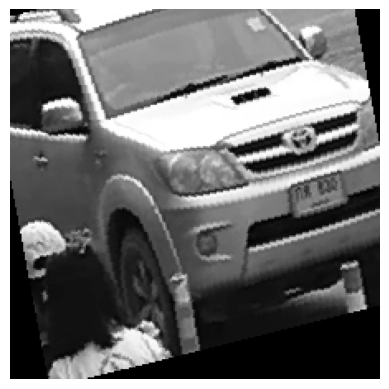

In [178]:
# DISPLAY RANDOM SAMPLE

# The arbitrary offset/scale is necessary to push the data into a visible range for Matplotlib.
# This makes the displayed image incorrect, but fulfills the request for a single-line display
plt.imshow(np.transpose(train_dataset[1023][0].numpy(), (1, 2, 0)), cmap='gray') 
plt.axis('off')
plt.show()

In [282]:
df_means = None
df_stds = None
umap_reducer = None

In [ ]:
# FEATURE EXTRACTION
from skimage.feature import hog
import umap

# input 2d grayscale numpy image
def lbp(im_np):
    im_lbp = im_np.copy()

    for i in range(1, im_np.shape[0] - 1):
        for j in range(1, im_np.shape[1] - 1):
            center = im_np[i, j]
            neighbour_patterns = []
            for l in range(-1, 2):
                for k in range(-1, 2):
                    if not (l == 0 and k == 0):
                        val = im_np[i+l, j+k]
                        neighbour_patterns.append(1 if val >= center else 0)
            texture = int(''.join(str(n) for n in neighbour_patterns), 2)
            im_lbp[i, j] = texture

    return im_lbp

     
def lbp_hist(im_lbp):
    hist = np.histogram(im_lbp.flatten(), bins=256)
    normalized_counts = hist[0] / hist[0].sum()
    return normalized_counts, hist[1]

import numpy as np

def simple_radial_features(magnitude_spectrum_log, num_rings=16):
    """Creates a 1D array of radial features."""
    H, W = magnitude_spectrum_log.shape
    center_y, center_x = H // 2, W // 2
    
    # 1. Create the distance (radius) map 'r'
    Y, X = np.ogrid[0:H, 0:W]
    r = np.sqrt((Y - center_y)**2 + (X - center_x)**2)

    # 2. Use histogram2d to efficiently bin magnitude values by radius
    # The output 'hist' is the sum of magnitudes in each ring
    # The bins are defined by the radius map 'r'
    hist, r_edges, mag_edges = np.histogram2d(
        r.ravel(),
        magnitude_spectrum_log.ravel(),
        bins=(num_rings, 1), # Only 1 bin for the magnitude dimension (summing)
        range=[[0, np.max(r)], [np.min(magnitude_spectrum_log), np.max(magnitude_spectrum_log)]]
    )
    
    # 3. Features are the average magnitude per bin (sum divided by count)
    # The counts of elements in each bin is needed for averaging (not included here for simplicity)
    # Returning the sum of magnitudes in each bin, which is often used directly as a feature
    return hist[:, 0]

def torchvis_to_pandas(dataset):
    df = None
    observation_count = len(dataset)
    # observation_count = 100
    for i in range(observation_count):
        if i % 50 == 0:
            print(i, '/', observation_count)

        im_np = torch.squeeze(dataset[i][0]).numpy()
        label = dataset[i][1]

        im_lbp = lbp(im_np)
        im_lbp_hist, _im_lbp_hist_bins = lbp_hist(im_lbp)

        hog_fd, hog_image = hog(
            im_np,
            orientations=8,
            pixels_per_cell=(8, 8),
            cells_per_block=(1, 1),
            visualize=True,
        )

        F = np.fft.fft2(im_np)
        F_shifted = np.fft.fftshift(F)
        magnitude_spectrum = np.abs(F_shifted)
        magnitude_spectrum_log = 20 * np.log(magnitude_spectrum + 1)
        radial_dft_feats = simple_radial_features(magnitude_spectrum_log)

        row = [*im_lbp_hist, *hog_fd, *radial_dft_feats, label]
        if df is None:
            lbp_cols = [f'lbp_{j}' for j in range(len(im_lbp_hist))]
            hog_cols = [f'hog_{j}' for j in range(len(hog_fd))]
            rdft_cols = [f'rdft_{j}' for j in range(len(radial_dft_feats))]
            column_names = lbp_cols + hog_cols + rdft_cols + ['label']
            df = pd.DataFrame([row], columns=column_names)
        else: df.loc[len(df)] = row
        
    return df

def normalize_df(df):
    global df_means
    global df_stds

    if df_means is None:
        df_means = df.mean()
    if df_stds  is None:
        df_stds = df.std()
    normalized_df = (df - df_means)/(df_stds + 1e-8)

    normalized_df['label'] = df['label']
    return normalized_df

def dimensionality_reduction(X):
    global umap_reducer
    
    X_dense = X.to_numpy().astype(np.float32)

    if umap_reducer is None:
        umap_reducer = umap.UMAP(
            n_components=50,  
            random_state=SEED,  
        )
        umap_reducer.fit(X_dense)
    
    reduced = umap_reducer.transform(X_dense)
    return reduced


def parse_torchvis(dataset):
    df = torchvis_to_pandas(dataset)
    df = normalize_df(df)
    y = df['label']
    X = df.drop(columns=['label'])
    X = dimensionality_reduction(X)

    return X, y

# example use
X, y = parse_torchvis(train_dataset)

0 / 100
50 / 100


/Users/liamshepard/Desktop/Skole/semester5/data/DDP/IT3212-Computer-Vision/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [286]:
y

0     2.0
1     3.0
2     4.0
3     4.0
4     2.0
     ... 
95    0.0
96    3.0
97    2.0
98    2.0
99    3.0
Name: label, Length: 100, dtype: float64

In [13]:
import numpy as np
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

# Load a pre-trained model (e.g., ResNet-18)
feature_extractor = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze weights (we only want the features, not to train the extractor)
for param in feature_extractor.parameters():
    param.requires_grad = False

# Remove the final classification layer (the last layer before the output)
# The features are the output of the AdaptiveAvgPool2d layer (512 features for ResNet-18)
feature_extractor = nn.Sequential(*(list(feature_extractor.children())[:-1]))
feature_extractor.eval() # Set to evaluation mode

def extract_features(data_loader):
    features_list = []
    labels_list = []
    
    with torch.no_grad(): # No need to calculate gradients for feature extraction
        for inputs, labels in tqdm(data_loader, desc="Extracting Features"):
            # Get the features (shape: [batch_size, 512, 1, 1])
            outputs = feature_extractor(inputs)
            
            # Flatten the features (shape: [batch_size, 512])
            outputs = outputs.squeeze().cpu().numpy()
            
            features_list.append(outputs)
            labels_list.append(labels.cpu().numpy())

    # Concatenate all batches
    X = np.concatenate(features_list)
    Y = np.concatenate(labels_list)
    return X, Y

# Extract features and labels for training and validation
X_train, Y_train = extract_features(train_loader)
X_val, Y_val = extract_features(val_loader)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/liamshepard/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:04<00:00, 9.68MB/s]
Extracting Features: 100%|██████████| 9/9 [00:04<00:00,  2.23it/s]


In [14]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize and train the XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=len(full_dataset.classes), 
    use_label_encoder=False, 
    eval_metric='merror',
    n_estimators=100
)

print("Training XGBoost Classifier...")
xgb_model.fit(X_train, Y_train)

# Predict and evaluate
Y_pred_xgb = xgb_model.predict(X_val)
xgb_accuracy = accuracy_score(Y_val, Y_pred_xgb)

print(f"\nXGBoost Validation Accuracy: {xgb_accuracy * 100:.2f}%")

Training XGBoost Classifier...


/Users/liamshepard/Desktop/Skole/semester5/data/DDP/IT3212-Computer-Vision/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [18:03:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Validation Accuracy: 87.40%


In [15]:
import torch.optim as optim

# Load a pre-trained ResNet-18 model
model_cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_cnn.fc.in_features # Get the number of input features for the final layer

# Replace the final fully connected layer (model_cnn.fc)
# The output size must match the number of your classes (4: hatchback, motorcycle, pickup, sedan, suv)
# Wait, based on your directory listing, you have 5 classes: hatchback, motorcycle, pickup, sedan, suv
num_classes = len(full_dataset.classes) # Should be 5
model_cnn.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_cnn = model_cnn.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cnn.parameters(), lr=0.001, momentum=0.9)

In [16]:
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # Zero the parameter gradients

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase (optional, but highly recommended)
        model.eval()
        # ... (similar loop logic for validation, without backward pass and optimizer step)
        
    return model

# Train the CNN
model_cnn = train_model(model_cnn, criterion, optimizer, num_epochs=5)
print("\nCNN Training Complete.")

Epoch 0/4
----------


Training Epoch 0: 100%|██████████| 33/33 [00:41<00:00,  1.25s/it]


Train Loss: 1.2149 Acc: 0.5506
Epoch 1/4
----------


Training Epoch 1: 100%|██████████| 33/33 [00:40<00:00,  1.24s/it]


Train Loss: 0.5578 Acc: 0.8483
Epoch 2/4
----------


Training Epoch 2: 100%|██████████| 33/33 [00:41<00:00,  1.24s/it]


Train Loss: 0.3118 Acc: 0.9208
Epoch 3/4
----------


Training Epoch 3: 100%|██████████| 33/33 [00:41<00:00,  1.26s/it]


Train Loss: 0.2020 Acc: 0.9580
Epoch 4/4
----------


Training Epoch 4: 100%|██████████| 33/33 [00:41<00:00,  1.26s/it]

Train Loss: 0.1249 Acc: 0.9885

CNN Training Complete.


In [18]:
import torch
from tqdm import tqdm

def evaluate_model(model, data_loader, criterion, device):
    # Set the model to evaluation mode
    model.eval() 
    
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    # Disable gradient calculations for inference (saves memory and speeds up computation)
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Validating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)

            # Update statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    # Calculate final loss and accuracy
    final_loss = running_loss / total_samples
    final_acc = running_corrects.double() / total_samples
    
    return final_loss, final_acc.item()



import torch.nn as nn

# Assuming these variables are defined from your training setup:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# criterion = nn.CrossEntropyLoss()
# model_cnn = ... # your trained model
# val_loader = ... # your validation data loader

final_val_loss, final_val_acc = evaluate_model(
    model=model_cnn,
    data_loader=val_loader,
    criterion=criterion,
    device=device
)

print(f"✅ Final Validation Loss: {final_val_loss:.4f}")
print(f"✅ Final Validation Accuracy: {final_val_acc * 100:.2f}%")

Validating: 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

✅ Final Validation Loss: 0.2391
✅ Final Validation Accuracy: 93.89%
